<div align=left>
Computational Morphology<br>
Paula Guerrero<br>
</div>

<h1 align=center>Building a Morphological Analyzer for Spanish Nouns and Adjectives</h1>

This notebook implements a computational model of Spanish plural formation using Finite State Transducers (FSTs). The model covers regular phonological and morphological rules, as well as lexical exceptions that cannot be derived by productive patterns.

In [1]:
%pip install pyfoma

## Implementation

### 1. DEFINING THE VOCABULARY

We begin by defining our lexicon of Spanish nouns and adjectives that will be used to test the plural formation rules. The size of the vocabulary is 105 lemmas, out of which 87 are nouns and 18 are adjectives. The model is therefore able to analyze and generate more than 210 word forms, since each lemma has one singular form and one or two plural forms.


In [34]:
from pyfoma import *

nouns = [
    "acción", "actriz", "ajedrez", "alumno", "amigo", "análisis", "árbol", "arroz",
    "bambú", "bebé", "buey",
    "café", "canción", "casa", "certamen", "champú", "chica", "cielo", "ciudad",
    "colibrí", "color", "comité", "compás", "composición", "corazón",
    "coche", "crimen", "crisis", "cruz",
    "dictamen", "dios", "disfraz", "doctor", "dominó",
    "esquí", "estación", "examen",
    "flor", "francés",
    "gato", "grúa",
    "hombre",
    "iglú", "imagen", "inglés", "interés", "israelí",
    "jabalí", "japonés", "joven", "jueves", "juez",
    "lápiz", "ley", "libro", "lunes", "luz",
    "marroquí", "margen", "menú", "mesa", "mes", "mujer",
    "nariz", "nación", "niño",
    "orden", "origen",
    "papel", "paraguas", "pared", "perro", "pez", "presidente",
    "raíz", "razón", "reloj", "resumen", "rey", "rubí",
    "silla", "sofá",
    "tabú", "tapiz", "tisú", "tórax",
    "viernes", "virgen", "virus", "voz", "volumen",
]

adjectives = [
    "audaz", "azul",
    "capaz", "común", "cortés",
    "débil", "difícil",
    "fácil", "feliz", "feroz", "fuerte",
    "grande",
    "montés",
    "rojo",
    "útil",
    "veloz", "verde",
]

### 2. CREATING THE BASE FSTs

We create the FSTs for our Spanish nouns and adjectives.

In [35]:

fsts = {}
fsts['nouns'] = FST.re('|'.join(n for n in nouns))
fsts['adjectives'] = FST.re('|'.join(adj for adj in adjectives))

### 3. MORPHOLOGICAL LABELS

We will employ the following abbreviations for morphological labels:
- `[N]` = Noun
- `[Adj]` = Adjective  
- `[Sg]` = Singular
- `[Pl]` = Plural

Spanish nouns and adjectives exhibit a two-way distinction for grammatical number: singular/plural. The singular marker is phonologically null `(-ø)`, i.e. an empty string. The plural marker is `-s`, which we represent as `+s` (where `+` is a morpheme boundary).

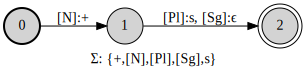

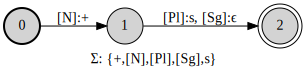

In [36]:
fsts['noun_suffixes'] = FST.re("( '[N]' '[Sg]'):'+' | ( '[N]' '[Pl]'):('+'s)")
fsts['noun_suffixes'].view()


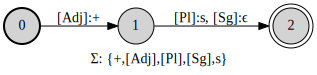

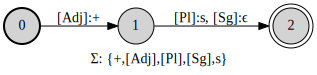

In [37]:
fsts['adj_suffixes'] = FST.re("( '[Adj]' '[Sg]'):'+' | ( '[Adj]' '[Pl]'):('+'s)")
fsts['adj_suffixes'].view()


### 4. COMPLETE LEXICON

We combine the lemmas with their morphological suffixes to create the full lexicon.

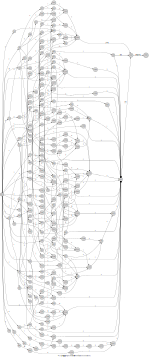

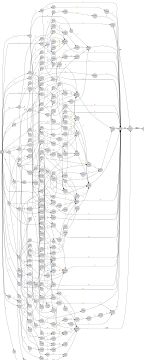

In [38]:
fsts['lexicon'] = FST.re("($nouns $noun_suffixes) | ($adjectives $adj_suffixes)", fsts)
fsts['lexicon'].view()

###**5. SPANISH ORTHOGRAPHIC ACCENT RULES AND PLURAL FORMATION**

Spanish words can be classified into three categories according to stress position:

1. **Oxytone (final stress)**: Stress falls on the last syllable
2. **Paroxytone (penultimate stress)**: Stress falls on the second-to-last syllable
3. **Proparoxytone (antepenultimate stress)**: Stress falls on the third-to-last syllable

### General orthographic accent rules (RAE & AALE, 2026b-c)

**Rule 1: Final Stress (Oxytone)**
- **Accented** when ending in vowel ("tisú"), /n/ ("nación"), or /s/ ("interés")
- **Unaccented** when ending in other consonants ("tapiz", "reloj")

**Rule 2: Penultimate Stress (Paroxytone)**
- **Accented** when ending in consonants other than /n/ and /s/ ("lápiz", "árbol")
- **Unaccented** when ending in vowel ("amigo"), /n/ ("joven"), or /s/ ("flores")

**Rule 3: Antepenultimate Stress (Proparoxytone)**
- **Always accented** ("híbrido", "régimen", "sílaba")

**Rule 4: Hiatus (two adjacent vowels from different syllables)**
- **Accented** when composed of a stressed closed vowel (í, ú) + open vowel (a, e, o), in either order: "raíz" (ra-íz), "grúa" (grú-a)
- **Unaccented** when composed of two open vowels: "marea" (ma-re-a)

**Note:** unlike hiatuses, diphthongs and triphthongs do not have ad-hoc accent rules. They are accented according to rules 1,2,3.


### Plural Formation (RAE, 2026; RAE & AALE, 2026a)

When the plural suffix is added, the stress pattern may change, which affects accent placement. The following template shows how stress interacts with plural formation:

### Resulting Template

| Index | Lemma Stress | Lemma Ending | Accent in SG | PL Suffix | Accent in PL | Example |
|-------|--------------|--------------|--------------|-----------|--------------|---------|
| **(1a)** | Oxytone | Open vowel (a,e,o) | Final | -s | Final | comité → comités |
| **(1b)** | Oxytone | Closed vowel (í,ú) | Final | -(e)s | Final | tisú → tisús / tisúes |
| **(1c)** | Oxytone | -n / -s | Final | -es | **No accent** | composición → composiciones |
| **(1d)** | Oxytone | Other consonant | No accent | -es | No accent | flor → flores |
| **(2a)** | Paroxytone | Vowel | No accent | -s | No accent | amigo → amigos |
| **(2b)** | Paroxytone |  -n | No accent | -es | **Antepenultimate** | joven → jóvenes |
| **(2c)** | Paroxytone | Other consonant | Penultimate | -es | **Antepenultimate** | lápiz → lápices |
| **(3a)** | Proparoxytone | Vowel | Antepenultimate | -s | Antepenultimate | híbrido → híbridos |
| **(3b)** | Proparoxytone | Consonant | Antepenultimate | -(s) | Antepenultimate | cárdigan → cárdigan(s) |
| **(4)** | **Invariable plurals** | Unstressed vowel+s | No accent | -s | No accent | virus → virus<br>lunes → lunes<br>crisis → crisis |
| **(5)** | **Stress-shifting exceptions** | Consonant |  | -es |  | régimen → regímenes<br>carácter → caracteres<br>espécimen → especímenes |



###**6. FST CHARACTER CLASSES**
Before implementing the transformation rules, we define some Spanish character classes which will serve for all the subsequent phonological and morphological rules.

###Consonants
All letters except vowels (includes /ñ/). Several FST rules will refer to this character class.

In [39]:
fsts['C'] = FST.re("[a-zñ]-[aeiou]")

###Vowels
Vowels without orthographic accent marks. Several FST rules will refer to this character class.

In [40]:
fsts['V'] = FST.re("[aeiou]")

###Open Vowels
Spanish open vowels are /a/, /e/, /o/. We define them for diphthong and hiatus detection.

In [41]:
fsts['openV'] = FST.re("[aeo]")

### Closed vowels
Spanish closed vowels are /i/, /u/. We define them for diphthong and hiatus detection (i.e. for syllable boundarization).

In [42]:
fsts["closedV"] = FST.re("[iu]")

### Accented closed vowels
We define the accented counterpart of closed vowels for optional /e/ insertion (FST rule 4).

In [43]:
fsts["accented_closedV"] = FST.re("[íú]")

###Syllable Structure
Every natural language syllable has a structure consists of three components: optional consonantal onset, obligatory vocalic nucleus and optional consonantal coda. Natural languages differ as to which phoneme clusters they allow or disallow in each of these syllable components.

For our Spanish FST grammar, we will only use syllables for counting unstressed syllables, hence we will only use unaccented vowels in the regular expressions:

- **Onset** (optional). May be monoconsonantal (p,t,b...) or biconsonantal (pr, tr, bl...). Regex: <br>
 `($C)?($C)?` <br>

- **Nucleus** (obligatory). May be monovocalic, bivocalic (diphthong) or trivocalic (triphthong). Regex:<br>
a. Monovocalic: <br>
`$V |` <br>
b. Diphthong. Spanish diphthongs are composed of an openV+closedV or closedV+openV or closedV+closedV, and may have an intervocalic orthographic "h" which is phonologically null (RAE & AALE, 2026c): <br>
`($openV)(h)?($closedV) | ($closedV)(h)?($openV) | ($closedV)(h)?($closedV) |` <br>
c. Triphthong. Spanish triphthongs are composed of closedV+openV+closedV (RAE & AALE, 2026c): <br>
`$closedV$openV$closedV`<br>

- **Coda** (optional). May be monoconsonantal (z,d,n...) or biconsonantal (ns, bs, rs...). Regex: <br>
 `($C)?($C)?`


In [44]:
fsts["unaccented_syl"] = FST.re("($C)?($C)?($V|($openV)(h)?($closedV) | ($closedV)(h)?($openV) | ($closedV)(h)?($closedV) | $closedV$openV$closedV)($C)?($C)?", fsts)

###**7. FST RULES**

To implement these patterns computationally, we need several phonological and orthographic rules:

### Rule 1: Z-Rule (`zrule`)
Change /z/ to /c/ before the plural suffix. The /z/ sound is spelled ⟨c⟩ before /e/ and /i/.

**Example:**
- lápiz + s → lápic**e**s


In [45]:
fsts['zrule'] = FST.re("$^rewrite(z:c / _ '+' s)")

### Rule 2: Invariable plurals (`invariables`)

Some nouns do not suffer any variation in their plural forms. These are stems that:
- end in unstressed vowel + /s/: crisis, virus

Examples:
- **el virus** → **los virus**
- **la crisis** → **las crisis**
- **el lunes** → **los lunes**

In [46]:
fsts['invariables'] = FST.re(
    "$^rewrite((('s'):'') / $V (s|x) '+' _)",
    fsts
)


### Rule 3: E-Insertion (`einsertion`)
Insert epenthetic /e/ between stem and plural suffix.

**Applies to:**
- consonant-final stems (except /n/, /s/, /x/): flor+s → flor**e**s

**Examples:**
- flor + s → flores
- papel + s → papeles


In [47]:
fsts['einsertion'] = FST.re("$^rewrite('':e / $C '+' _  s)", fsts)


### Rule 4: Optional E-Insertion (`optional_e`)
Optionally insert /e/ after stressed closed vowels (/í/ or /ú/).

**Examples:**
- rubí + s → rubís / rubíes
- tisú + s → tisús / tisúes



In [48]:
fsts['optional_e'] = FST.re("$^rewrite('':?e / $accented_closedV '+' _  s)", fsts)

### Rule 5: Accent Removal (`$remove_accent_oxy`)
Remove the accent mark on oxytones ending in /n/ or /s/, since the  suffix -es contributes an additional syllable which shifts the stress to penultimate position, thereby not requiring an accent.

**Example:**
- composición + es → composiciones




In [49]:
fsts['remove_accent_oxy'] = FST.re(
    "$^rewrite((á:a | é:e | í:i | ó:o | ú:u) / _ (n|s) '+' es)",
    fsts
)

### Rule 6: Accent addition (`$add_accent_parox`)
Add an accent mark on paroxytones ending in /n/, which are not accented in the singular, but are accented in the plural because the -es turns these words into proparoxytones, thereby requiring an accent.

**Examples:**
- examen + es → exámenes



In [50]:
fsts["add_accent_parox"] = FST.re(
    "$^rewrite((a:á | e:é | i:í | o:ó | u:ú) / ($unaccented_syl)* _ $unaccented_syl n '+' es)",
    fsts
)


### Rule 7: Cleanup
Remove all morpheme boundary markers (+).

**Example:**
- flor+es → flores

In [51]:
fsts['cleanup'] = FST.re("$^rewrite('+':'')")


### Grammar formation

We compose all the rules to create the Spanish plural grammar, respecting rule ordering:

0. `$lexicon` : Start with lexicon (stems + morphological suffixes)
1. `$zrule` : Change stem-final /z/ into /c/
2. `$invariables` : Remove the plural suffix in invariable nouns
3. `$einsertion` : Apply /e/ insertion rule  
4. `$optional_e` : Apply optional /e/ insertion
5. `$remove_accent_oxy` Remove accent on oxytones ending in /n/ or /s/
6. `$add_accent_parox` : Add accent on paroxytones ending in /n/
7. `$cleanup` : Remove morpheme boundaries (+)

In [52]:
fsts["grammar"] = FST.re(""" $lexicon @ $zrule @ $invariables @ $einsertion @ $optional_e @ $add_accent_parox @ $remove_accent_oxy @ $cleanup """, fsts)


### STRESS-SHIFTING EXCEPTIONS (Hardcoded)

Not all Spanish plurals follow productive accent rules. There are several exceptions (RAE & AALE 2026a).

One type of exceptions is stress-shifting plurals. According to the RAE (2026), there are three nouns in Spanish that shift their stressed syllable to the right when adding an -es, thereby exhibiting the same stress position in SG and PL:

- Proparoxytone → proparoxytone: <br>
 "régimen" → "regímenes" (not "régimenes") <br>
 "espécimen" → "especímenes" (not "espécímenes")
- Paroxytone → paroxytone: <br>
"carácter" → "caracteres" (not "carácteres")


These exceptions must be listed in the lexicon, since this stress pattern is not productive but a prescriptive artifact in modern Spanish, as shown by Bermúdez-Otero & Torres‑Tamarit (in press).


In [53]:
fsts['exceptions'] = FST.re("""(régimen '[N]' '[Pl]'):(regímenes) |"""
                            """(régimen '[N]' '[Sg]'):(régimen) |"""
                            """(espécimen '[N]' '[Pl]'):(especímenes) |"""
                            """(espécimen '[N]' '[Sg]'):(espécimen) |"""
                            """(carácter '[N]' '[Pl]'):(caracteres) |"""
                            """(carácter '[N]' '[Sg]'):(carácter)""")

The final system `fsts['spanish']` combines the regular grammar with exceptions.

In [54]:
fsts['spanish'] = FST.re("$grammar | $exceptions ", fsts)



### 8. TESTING THE SYSTEM


### Generate All Paradigms

We can view all possible singular-plural pairs generated by our system:

In [55]:
print(Paradigm(fsts['spanish'], ".*"))

acción       [N][Pl]    acciones       
acción       [N][Sg]    acción         
actriz       [N][Pl]    actrices       
actriz       [N][Sg]    actriz         
ajedrez      [N][Pl]    ajedreces      
ajedrez      [N][Sg]    ajedrez        
alumno       [N][Pl]    alumnos        
alumno       [N][Sg]    alumno         
amigo        [N][Pl]    amigos         
amigo        [N][Sg]    amigo          
análisis     [N][Pl]    análisis       
análisis     [N][Sg]    análisis       
arroz        [N][Pl]    arroces        
arroz        [N][Sg]    arroz          
audaz        [Adj][Pl]  audaces        
audaz        [Adj][Sg]  audaz          
azul         [Adj][Pl]  azules         
azul         [Adj][Sg]  azul           
bambú        [N][Pl]    bambúes        
bambú        [N][Pl]    bambús         
bambú        [N][Sg]    bambú          
bebé         [N][Pl]    bebés          
bebé         [N][Sg]    bebé           
buey         [N][Pl]    bueyes         
buey         [N][Sg]    buey           


### Generate and Analyze

The system can also be evaluated by generating words according to the FST rules or by analyzing morphologically specific words.


In [56]:
# Test individual rules
list(fsts['remove_accent_oxy'].generate("composición+es"))

['composicion+es']

['composicion+es']

In [57]:
list(fsts['add_accent_parox'].generate("joven+es"))

['jóven+es']

['jóven+es']

In [58]:
# Test morphological analyzer
list(fsts['spanish'].generate("francés[N][Pl]"))

['franceses']

['franceses']

In [59]:
list(fsts['spanish'].generate("joven[N][Pl]"))

['jóvenes']

['jóvenes']

In [60]:
list(fsts['spanish'].analyze("especímenes"))

['espécimen[N][Pl]']

['espécimen[N][Pl]']

In [61]:
list(fsts['spanish'].analyze("monteses"))

['montés[Adj][Pl]']

['montés[Adj][Pl]']

In [62]:
list(fsts['spanish'].analyze("francés"))

['francés[N][Sg]']

['francés[N][Sg]']

In [63]:
list(fsts['spanish'].analyze("mes"))

['mes[N][Pl]', 'mes[N][Sg]']

['mes[N][Sg]', 'mes[N][Pl]']

### Automated display of correct forms


In [64]:
# Only show the correct forms
inputs = [
    "acción '[N]' '[Pl]'", "acción '[N]' '[Sg]'",
    "actriz '[N]' '[Pl]'", "actriz '[N]' '[Sg]'",
    "ajedrez '[N]' '[Pl]'", "ajedrez '[N]' '[Sg]'",
    "alumno '[N]' '[Pl]'", "alumno '[N]' '[Sg]'",
    "amigo '[N]' '[Pl]'", "amigo '[N]' '[Sg]'",
    "análisis '[N]' '[Pl]'", "análisis '[N]' '[Sg]'",
    "árbol '[N]' '[Pl]'", "árbol '[N]' '[Sg]'",
    "arroz '[N]' '[Pl]'", "arroz '[N]' '[Sg]'",

    "audaz '[Adj]' '[Pl]'", "audaz '[Adj]' '[Sg]'",
    "azul '[Adj]' '[Pl]'", "azul '[Adj]' '[Sg]'",

    "bambú '[N]' '[Pl]'", "bambú '[N]' '[Pl]'", "bambú '[N]' '[Sg]'",
    "bebé '[N]' '[Pl]'", "bebé '[N]' '[Sg]'",
    "buey '[N]' '[Pl]'", "buey '[N]' '[Sg]'",

    "café '[N]' '[Pl]'", "café '[N]' '[Sg]'",
    "canción '[N]' '[Pl]'", "canción '[N]' '[Sg]'",
    "capaz '[Adj]' '[Pl]'", "capaz '[Adj]' '[Sg]'",
    "carácter '[N]' '[Pl]'", "carácter '[N]' '[Sg]'",
    "casa '[N]' '[Pl]'", "casa '[N]' '[Sg]'",
    "certamen '[N]' '[Pl]'", "certamen '[N]' '[Sg]'",
    "champú '[N]' '[Pl]'", "champú '[N]' '[Pl]'", "champú '[N]' '[Sg]'",
    "chica '[N]' '[Pl]'", "chica '[N]' '[Sg]'",
    "ciudad '[N]' '[Pl]'", "ciudad '[N]' '[Sg]'",
    "coche '[N]' '[Pl]'", "coche '[N]' '[Sg]'",
    "colibrí '[N]' '[Pl]'", "colibrí '[N]' '[Pl]'", "colibrí '[N]' '[Sg]'",
    "color '[N]' '[Pl]'", "color '[N]' '[Sg]'",
    "comité '[N]' '[Pl]'", "comité '[N]' '[Sg]'",
    "composición '[N]' '[Pl]'", "composición '[N]' '[Sg]'",
    "compás '[N]' '[Pl]'", "compás '[N]' '[Sg]'",
    "común '[Adj]' '[Pl]'", "común '[Adj]' '[Sg]'",
    "corazón '[N]' '[Pl]'", "corazón '[N]' '[Sg]'",
    "cortés '[Adj]' '[Pl]'", "cortés '[Adj]' '[Sg]'",
    "crimen '[N]' '[Pl]'", "crimen '[N]' '[Sg]'",
    "crisis '[N]' '[Pl]'", "crisis '[N]' '[Sg]'",
    "cruz '[N]' '[Pl]'", "cruz '[N]' '[Sg]'",

    "débil '[Adj]' '[Pl]'", "débil '[Adj]' '[Sg]'",
    "dictamen '[N]' '[Pl]'", "dictamen '[N]' '[Sg]'",
    "difícil '[Adj]' '[Pl]'", "difícil '[Adj]' '[Sg]'",
    "dios '[N]' '[Pl]'", "dios '[N]' '[Sg]'",
    "disfraz '[N]' '[Pl]'", "disfraz '[N]' '[Sg]'",
    "doctor '[N]' '[Pl]'", "doctor '[N]' '[Sg]'",
    "dominó '[N]' '[Pl]'", "dominó '[N]' '[Sg]'",

    "espécimen '[N]' '[Pl]'", "espécimen '[N]' '[Sg]'",
    "esquí '[N]' '[Pl]'", "esquí '[N]' '[Pl]'", "esquí '[N]' '[Sg]'",
    "estación '[N]' '[Pl]'", "estación '[N]' '[Sg]'",
    "examen '[N]' '[Pl]'", "examen '[N]' '[Sg]'",

    "feliz '[Adj]' '[Pl]'", "feliz '[Adj]' '[Sg]'",
    "feroz '[Adj]' '[Pl]'", "feroz '[Adj]' '[Sg]'",
    "flor '[N]' '[Pl]'", "flor '[N]' '[Sg]'",
    "francés '[N]' '[Pl]'", "francés '[N]' '[Sg]'",
    "fuerte '[Adj]' '[Pl]'", "fuerte '[Adj]' '[Sg]'",
    "fácil '[Adj]' '[Pl]'", "fácil '[Adj]' '[Sg]'",

    "gato '[N]' '[Pl]'", "gato '[N]' '[Sg]'",
    "grande '[Adj]' '[Pl]'", "grande '[Adj]' '[Sg]'",
    "grúa '[N]' '[Pl]'", "grúa '[N]' '[Sg]'",

    "hombre '[N]' '[Pl]'", "hombre '[N]' '[Sg]'",

    "iglú '[N]' '[Pl]'", "iglú '[N]' '[Pl]'", "iglú '[N]' '[Sg]'",
    "imagen '[N]' '[Pl]'", "imagen '[N]' '[Sg]'",
    "inglés '[N]' '[Pl]'", "inglés '[N]' '[Sg]'",
    "interés '[N]' '[Pl]'", "interés '[N]' '[Sg]'",
    "israelí '[N]' '[Pl]'", "israelí '[N]' '[Pl]'", "israelí '[N]' '[Sg]'",

    "jabalí '[N]' '[Pl]'", "jabalí '[N]' '[Pl]'", "jabalí '[N]' '[Sg]'",
    "japonés '[N]' '[Pl]'", "japonés '[N]' '[Sg]'",
    "joven '[N]' '[Pl]'", "joven '[N]' '[Sg]'",
    "jueves '[N]' '[Pl]'", "jueves '[N]' '[Sg]'",
    "juez '[N]' '[Pl]'", "juez '[N]' '[Sg]'",

    "lápiz '[N]' '[Pl]'", "lápiz '[N]' '[Sg]'",
    "ley '[N]' '[Pl]'", "ley '[N]' '[Sg]'",
    "libro '[N]' '[Pl]'", "libro '[N]' '[Sg]'",
    "lunes '[N]' '[Pl]'", "lunes '[N]' '[Sg]'",
    "luz '[N]' '[Pl]'", "luz '[N]' '[Sg]'",

    "margen '[N]' '[Pl]'", "margen '[N]' '[Sg]'",
    "marroquí '[N]' '[Pl]'", "marroquí '[N]' '[Pl]'", "marroquí '[N]' '[Sg]'",
    "menú '[N]' '[Pl]'", "menú '[N]' '[Pl]'", "menú '[N]' '[Sg]'",
    "mes '[N]' '[Pl]'", "mes '[N]' '[Sg]'",
    "mesa '[N]' '[Pl]'", "mesa '[N]' '[Sg]'",
    "montés '[Adj]' '[Pl]'", "montés '[Adj]' '[Sg]'",
    "mujer '[N]' '[Pl]'", "mujer '[N]' '[Sg]'",

    "nación '[N]' '[Pl]'", "nación '[N]' '[Sg]'",
    "nariz '[N]' '[Pl]'", "nariz '[N]' '[Sg]'",
    "niño '[N]' '[Pl]'", "niño '[N]' '[Sg]'",

    "orden '[N]' '[Pl]'", "orden '[N]' '[Sg]'",
    "origen '[N]' '[Pl]'", "origen '[N]' '[Sg]'",

    "papel '[N]' '[Pl]'", "papel '[N]' '[Sg]'",
    "paraguas '[N]' '[Pl]'", "paraguas '[N]' '[Sg]'",
    "pared '[N]' '[Pl]'", "pared '[N]' '[Sg]'",
    "perro '[N]' '[Pl]'", "perro '[N]' '[Sg]'",
    "pez '[N]' '[Pl]'", "pez '[N]' '[Sg]'",
    "presidente '[N]' '[Pl]'", "presidente '[N]' '[Sg]'",

    "raíz '[N]' '[Pl]'", "raíz '[N]' '[Sg]'",
    "razón '[N]' '[Pl]'", "razón '[N]' '[Sg]'",
    "reloj '[N]' '[Pl]'", "reloj '[N]' '[Sg]'",
    "resumen '[N]' '[Pl]'", "resumen '[N]' '[Sg]'",
    "rey '[N]' '[Pl]'", "rey '[N]' '[Sg]'",
    "rojo '[Adj]' '[Pl]'", "rojo '[Adj]' '[Sg]'",
    "rubí '[N]' '[Pl]'", "rubí '[N]' '[Pl]'", "rubí '[N]' '[Sg]'",
    "régimen '[N]' '[Pl]'", "régimen '[N]' '[Sg]'",

    "silla '[N]' '[Pl]'", "silla '[N]' '[Sg]'",
    "sofá '[N]' '[Pl]'", "sofá '[N]' '[Sg]'",

    "tabú '[N]' '[Pl]'", "tabú '[N]' '[Pl]'", "tabú '[N]' '[Sg]'",
    "tapiz '[N]' '[Pl]'", "tapiz '[N]' '[Sg]'",
    "tisú '[N]' '[Pl]'", "tisú '[N]' '[Pl]'", "tisú '[N]' '[Sg]'",
    "tórax '[N]' '[Pl]'", "tórax '[N]' '[Sg]'",

    "útil '[Adj]' '[Pl]'", "útil '[Adj]' '[Sg]'",

    "veloz '[Adj]' '[Pl]'", "veloz '[Adj]' '[Sg]'",
    "verde '[Adj]' '[Pl]'", "verde '[Adj]' '[Sg]'",
    "viernes '[N]' '[Pl]'", "viernes '[N]' '[Sg]'",
    "virgen '[N]' '[Pl]'", "virgen '[N]' '[Sg]'",
    "virus '[N]' '[Pl]'", "virus '[N]' '[Sg]'",
    "volumen '[N]' '[Pl]'", "volumen '[N]' '[Sg]'",
    "voz '[N]' '[Pl]'", "voz '[N]' '[Sg]'"

]

outputs = [
    "acciones", "acción",
    "actrices", "actriz",
    "ajedreces", "ajedrez",
    "alumnos", "alumno",
    "amigos", "amigo",
    "análisis", "análisis",
    "árboles", "árbol",
    "arroces", "arroz",

    "audaces", "audaz",
    "azules", "azul",

    "bambúes", "bambús", "bambú",
    "bebés", "bebé",
    "bueyes", "buey",

    "cafés", "café",
    "canciones", "canción",
    "capaces", "capaz",
    "caracteres", "carácter",
    "casas", "casa",
    "certámenes", "certamen",
    "champúes", "champús", "champú",
    "chicas", "chica",
    "ciudades", "ciudad",
    "coches", "coche",
    "colibríes", "colibrís", "colibrí",
    "colores", "color",
    "comités", "comité",
    "composiciones", "composición",
    "compases", "compás",
    "comunes", "común",
    "corazones", "corazón",
    "corteses", "cortés",
    "crímenes", "crimen",
    "crisis", "crisis",
    "cruces", "cruz",

    "débiles", "débil",
    "dictámenes", "dictamen",
    "difíciles", "difícil",
    "dioses", "dios",
    "disfraces", "disfraz",
    "doctores", "doctor",
    "dominós", "dominó",

    "especímenes", "espécimen",
    "esquíes", "esquís", "esquí",
    "estaciones", "estación",
    "exámenes", "examen",

    "felices", "feliz",
    "feroces", "feroz",
    "flores", "flor",
    "franceses", "francés",
    "fuertes", "fuerte",
    "fáciles", "fácil",

    "gatos", "gato",
    "grandes", "grande",
    "grúas", "grúa",

    "hombres", "hombre",

    "iglúes", "iglús", "iglú",
    "imágenes", "imagen",
    "ingleses", "inglés",
    "intereses", "interés",
    "israelíes", "israelís", "israelí",

    "jabalíes", "jabalís", "jabalí",
    "japoneses", "japonés",
    "jóvenes", "joven",
    "jueves", "jueves",
    "jueces", "juez",

    "lápices", "lápiz",
    "leyes", "ley",
    "libros", "libro",
    "lunes", "lunes",
    "luces", "luz",

    "márgenes", "margen",
    "marroquíes", "marroquís", "marroquí",
    "menúes", "menús", "menú",
    "meses", "mes",
    "mesas", "mesa",
    "monteses", "montés",
    "mujeres", "mujer",

    "naciones", "nación",
    "narices", "nariz",
    "niños", "niño",

    "órdenes", "orden",
    "orígenes", "origen",

    "papeles", "papel",
    "paraguas", "paraguas",
    "paredes", "pared",
    "perros", "perro",
    "peces", "pez",
    "presidentes", "presidente",

    "raíces", "raíz",
    "razones", "razón",
    "relojes", "reloj",
    "resúmenes", "resumen",
    "reyes", "rey",
    "rojos", "rojo",
    "rubíes", "rubís", "rubí",
    "regímenes", "régimen",

    "sillas", "silla",
    "sofás", "sofá",

    "tabúes", "tabús", "tabú",
    "tapices", "tapiz",
    "tisúes", "tisús", "tisú",
    "tórax", "tórax",

    "útiles", "útil",

    "veloces", "veloz",
    "verdes", "verde",
    "viernes", "viernes",
    "vírgenes", "virgen",
    "virus", "virus",
    "volúmenes", "volumen",
    "voces", "voz",

]

fsts['inputs'] = FST.re('|'.join([w for w in inputs]))
fsts['outputs'] = FST.re('|'.join([w for w in outputs]))
fsts['test'] = FST.re("$inputs @ $spanish @ $outputs", fsts)
print(Paradigm(fsts['test'], ".*"))

acción       [N][Pl]    acciones       
acción       [N][Sg]    acción         
actriz       [N][Pl]    actrices       
actriz       [N][Sg]    actriz         
ajedrez      [N][Pl]    ajedreces      
ajedrez      [N][Sg]    ajedrez        
alumno       [N][Pl]    alumnos        
alumno       [N][Sg]    alumno         
amigo        [N][Pl]    amigos         
amigo        [N][Sg]    amigo          
análisis     [N][Pl]    análisis       
análisis     [N][Sg]    análisis       
arroz        [N][Pl]    arroces        
arroz        [N][Sg]    arroz          
audaz        [Adj][Pl]  audaces        
audaz        [Adj][Sg]  audaz          
azul         [Adj][Pl]  azules         
azul         [Adj][Sg]  azul           
bambú        [N][Pl]    bambúes        
bambú        [N][Pl]    bambús         
bambú        [N][Sg]    bambú          
bebé         [N][Pl]    bebés          
bebé         [N][Sg]    bebé           
buey         [N][Pl]    bueyes         
buey         [N][Sg]    buey           


### Automated display of incorrect forms


In [65]:
#  Only show the incorrect forms
fsts['inputs'] = FST.re('|'.join([w for w in inputs]))
fsts['outputs'] = FST.re('|'.join([w for w in outputs]))
fsts['test'] = FST.re("$inputs @ $spanish @ (.* - $outputs)", fsts)
print(Paradigm(fsts['test'], ".*"))

##**9. REFERENCES**

- Bermúdez-Otero, R. & Torres-Tamarit F. (in press). Modularity, cyclicity, and constrained non-uniformity in Spanish stress assignment. *Linguistic Inquiry*.  
- Real Academia Española (RAE). (2026). Plural. In *Diccionario panhispánico de dudas* (2nd Ed.). https://www.rae.es/dpd/plural
- Real Academia Española (RAE) & Asociación de Academias de la Lengua  Española (AALE). (2026a). La formación del plural. Plurales en -s y plurales en -es. Reglas generales. In *Nueva gramática de la lengua española*. https://www.rae.es/gram%C3%A1tica/morfolog%C3%ADa/la-formaci%C3%B3n-del-plural-plurales-en-s-y-plurales-en-es-reglas-generales
- Real Academia Española (RAE) y Asociación de Academias de la Lengua  Española (AALE). (2026b).
Las reglas de acentuación gráfica. In *El buen uso del español*. https://www.rae.es/buen-uso-español/las-reglas-de-acentuación-gráfica
- Real Academia Española (RAE) y Asociación de Academias de la Lengua  Española (AALE). (2026c).
Acentuación de palabras con diptongo, triptongo o hiato. In *El buen uso del español*. https://www.rae.es/buen-uso-español/acentuación-de-palabras-con-diptongo-triptongo-o-hiato






